# Lesson 6 | Binary Splits & Becoming a Kaggle Gangster
> Random Forests are Amazing, Learn to Crush Kaggle Comps

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-01-24-Fastai%20Lesson%206.ipynb)

## Lecture Content

### Prepping Titanic Data

First we'll grab the titanic data like we did last lesson and pre process the data as we did before

In [15]:
from fastai.imports import *

In [2]:
path = Path("../data/titanic/")

df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/"test.csv")
modes = df.mode().iloc[0]

The other thing we'll do differently is utilise pandas to convert a categorical variable to a categorical data type which will handle the encoding for us by creating a vocab in the backend but displaying us the text data we're used to

In [9]:
def process_titanic(df):
    df["Fare"] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df["LogFare"] = np.log1p(df["Fare"])
    df["Embarked"] = pd.Categorical(df.Embarked)
    df["Sex"] = pd.Categorical(df.Sex)
    
process_titanic(df)
process_titanic(test_df)

In [13]:
categorical_columns = ["Sex", "Embarked"]
continuous_columns = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dependent = "Survived"

To illustrate the pandas vocab --> numbers vocab explanation, lets check quickly the "Sex" column and then see the corresponding .cat.codes attribute which houses the matching values

In [12]:
df.Sex.head(), df.Sex.cat.codes.head()

(0      male
 1    female
 2    female
 3    female
 4      male
 Name: Sex, dtype: category
 Categories (2, object): ['female', 'male'],
 0    1
 1    0
 2    0
 3    0
 4    1
 dtype: int8)

And you can see that male = 1, female = 0, as well as seeing the categories in the vocab list which in this case only includes two.

### Binary Splits

We're going to work our way up to Gradient Boosted Machines and Random Forests but in order to do that we have to be able to create decision trees and these are made of binary splits. We know where we're heading, lets now go from the bottom up and construct our way to gradient boosting.

A binary split is simply a rule where all the data is placed into one of two groups based on some threshold, hence binary, group 0 or 1. In our situation using the above "Sex" column, we could split males and females into two groups by thresholding the rows above or below `0.5`. Lets first have a look at the data visually to see what a split like this might perform like.

[Text(0.5, 1.0, 'Histogram')]

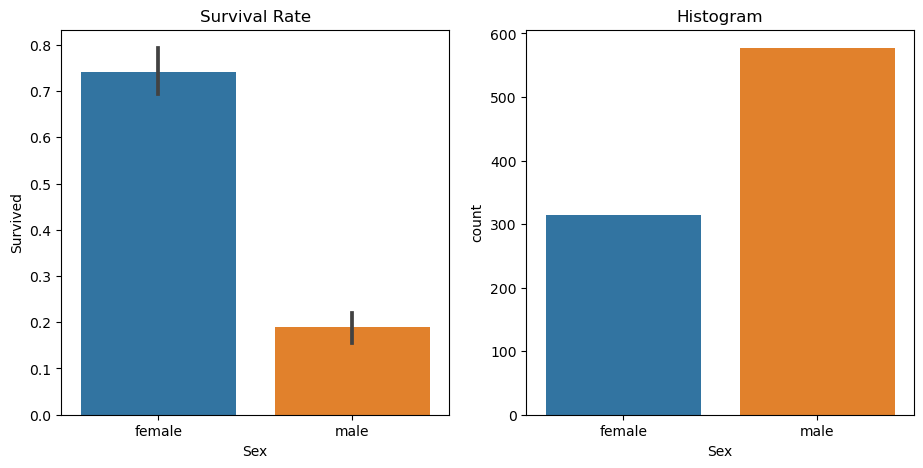

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(11,5))
sns.barplot(data=df,
            y=dependent,
            x="Sex",
            ax=axs[0]).set(title="Survival Rate")
sns.countplot(data=df,
             x="Sex",
             ax=axs[1]).set(title="Histogram")

The survival rate differences for males and females are starkly different, females have over triple the survival rate of males so if we used our binary split, we wouldn't actually perform too badly! Lets test that out just for illustration.

Lets setup a train and validation dataset as well as convert our categorical attributes back to numerical codes which we can do with lambda.

In [21]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(27)
train_df, validation_df = train_test_split(df, test_size=0.25)
train_df[categorical_columns] = train_df[categorical_columns].apply(lambda x: x.cat.codes)
validation_df[categorical_columns] = validation_df[categorical_columns].apply(lambda x: x.cat.codes)

Lets now make our 'y' / dependent variable and our 'x's or independent variable

In [24]:
def xs_y(df):
    xs = df[categorical_columns+continuous_columns].copy()
    return xs, df[dependent] if dependent in df else None

train_xs, train_y = xs_y(train_df)
validation_xs, validation_y = xs_y(validation_df)

Now lets predict using our binary split, where all males die and all females live

In [25]:
preds = validation_xs.Sex == 0

Lets use mean absolute error which we've used in previous lessons to test our performance

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validation_y, preds)

0.242152466367713

Now we've used a categorical column to split which has very strong delineation between values but we can do this with continues variables as well. Lets visualise LogFare and try and pick a good threshold, we're going to use slightly different visualisations because the data is continues. We can however have a very similar view, we can use a boxplot / boxenplot (more quantiles/partitions) and a kernel density plot which will bucket our continues value into tiny little buckets and then histogram those buckets to produce a similar effect as a histogram. Lets have a look

<AxesSubplot: xlabel='LogFare', ylabel='Density'>

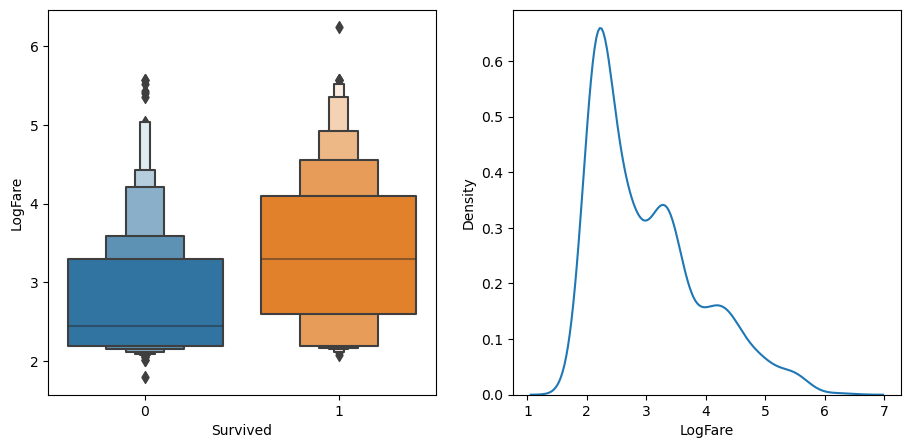

In [28]:
df_fare = train_df[train_df.LogFare>0]

fig,axs = plt.subplots(1,2,figsize=(11,5))
sns.boxenplot(data=df_fare, x=dependent, y="LogFare",ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare",ax=axs[1])

If we checkout the boxenplot on the left, we can see the average logfare of not surviving is about 2.5, for those that lived, its about 3.2, if you paid more for a ticket, you were more likely to survive, go figure.

Lets make another model based on this split

In [29]:
preds = validation_xs.LogFare > 2.7
mean_absolute_error(validation_y, preds)

0.40358744394618834

Almost twice as bad as the split by Sex...

Lets now write a way to test more columns and more thresholds, we'll first write a scoring function to return how good our splits are so that we can compare them to others quickly. We're also going to introduce the concept of 'impurity' to each group in the sense that after we've split a group, we want all the rows of the group to be like the rest of them, we'd like 'pure' groups.

We can measure this similarity / purity by taking the standard deviation of the dependent variable, the larger this value is, the more different the rows are to each other, we'll then multiply this score by the value of the rows to punish larger groups of equal purity.

In [30]:
def side_score(side, y):
    total = side.sum()
    if total<=1: return 0
    return y[side].std()*total

This will give us a score for a particular 'side' or group, lets now calculate the score for a particular split by adding up the total score of both sides

In [31]:
def score(column, y, split):
    lhs = column<=split
    return (side_score(lhs,y) + side_score(~lhs,y))/len(y)

Also the '~' operator we discussed in previous lessons, I won't repeat the docs or explanation here, try see if you can find it in my blog!

Lets test it out on our first split by Sex and see the 'impurity' score

In [33]:
score(train_xs["Sex"], train_y, 0.5)

0.40174577324058475

Now lets try LogFare again

In [34]:
score(train_xs["LogFare"], train_y, 2.7)

0.4670131181830465

Great, not quite the same difference in magnitude of error but our "Sex" split is far more effective than our LogFare split.

Lets muck around with an interactive version, excuse this if you're reading in quarto, checkout the colab notebook link at the top if you'd like to play around, otherwise I may come back and create an altair tool to play with at a later date.

In [39]:
def iscore(name, split):
    column = train_xs[name]
    return score(column, train_y, split)
    
from ipywidgets import interact
interact(name=continuous_columns, split=15.15)(iscore)

interactive(children=(Dropdown(description='name', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), val…

<function __main__.iscore(name, split)>

In [40]:
interact(name=categorical_columns, split=2)(iscore)

interactive(children=(Dropdown(description='name', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=…

<function __main__.iscore(name, split)>

Similar to playing around with the fit function from the earlier lessons, this hammers home the point of finding the lowest loss but its finicky when manual like this, lets automatically find the best splits by looking at all the possibly splits we could do and find the best loss. Lets try it with Age

In [41]:
name = "Age"
column = train_xs[name]
unique = column.unique()
unique.sort()
unique

array([ 0.67,  0.75,  0.83,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,
        7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  , 14.  , 14.5 ,
       15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 , 21.  , 22.  ,
       23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 , 29.  ,
       30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  , 34.  , 35.  , 36.  ,
       37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  , 43.  , 44.  ,
       45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  ,
       53.  , 54.  , 55.  , 55.5 , 56.  , 57.  , 58.  , 59.  , 60.  ,
       61.  , 62.  , 63.  , 64.  , 65.  , 66.  , 70.  , 70.5 , 71.  ,
       74.  , 80.  ])

This gives us all the possible Age values we could use, lets checkout the scores

In [70]:
scores = np.array([score(column,train_y,o) for o in unique if not np.isnan(o)])
unique[scores.argmin()], scores

(1.0,
 array([0.48594849, 0.48404762, 0.48213925, 0.48022329, 0.48618568,
        0.4850268 , 0.48466283, 0.4829376 , 0.48298419, 0.48345047,
        0.48304092, 0.48346219, 0.48417261, 0.4841437 , 0.48378607,
        0.48303173, 0.48299166, 0.48333772, 0.4821711 , 0.48240352,
        0.48284921, 0.48367573, 0.48462972, 0.48557444, 0.48570274,
        0.48645229, 0.48610302, 0.48649283, 0.48693277, 0.48688775,
        0.48647636, 0.48628599, 0.48690896, 0.48683546, 0.48672752,
        0.48675081, 0.4867205 , 0.48659482, 0.48699805, 0.48715547,
        0.48717052, 0.4871025 , 0.48723429, 0.4872322 , 0.48710254,
        0.48719272, 0.48709139, 0.48714029, 0.48699734, 0.48704597,
        0.48707436, 0.48714085, 0.48715271, 0.48720485, 0.48718624,
        0.4872376 , 0.48726382, 0.48723709, 0.4871586 , 0.48698007,
        0.48677986, 0.48696898, 0.48705849, 0.48691477, 0.48694238,
        0.48685455, 0.48695552, 0.48647079, 0.48675047, 0.48577837,
        0.48619859, 0.48611863, 0.48652727

Most of the scores are quite similar, but setting our age to "1" as the threshold will give us the best score, this is at index 4 in our unique ages. We can have a quick look at all the losses by age as well:

Text(0, 0.5, 'Loss')

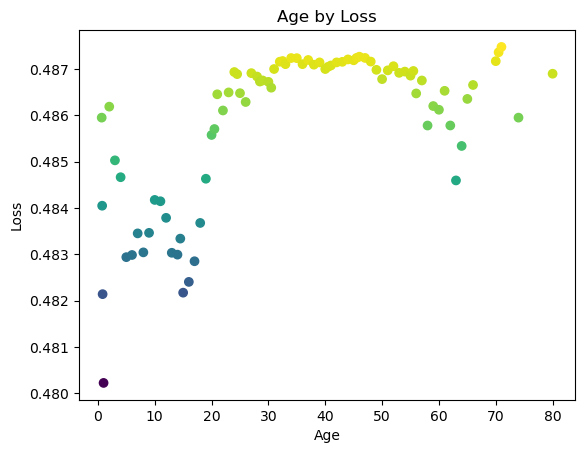

In [74]:
plt.scatter(x=unique, y=scores,c=scores)
plt.title("Age by Loss")
plt.xlabel("Age")
plt.ylabel("Loss")

Kind of a funny shape as there's also a decent split at age ~65 but still by far splitting at age ~1 has the lowest error